# **Proyek Sistem Rekomendasi**

* Nama : Moh. Aflah Azzaky
* Email : aflahazzaki123@gmail.com
* ID Dicoding : aflahazzaky
* Dataset : [Movie Recommendation Data](https://www.kaggle.com/datasets/rohan4050/movie-recommendation-data)

## **Data Understanding**

### **Import Library**

**Menginstall library yang dibutuhkan dalam pembuatan sistem rekomendasi film**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import warnings
import keras
from keras import layers
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

### **Data Loading**

**Menginstall Kaggle dan mengunduh dataset**

In [2]:
!pip install kaggle

os.environ['KAGGLE_KEY'] = 'bb18e594229a6d36e6251ef61baea580'
os.environ['KAGGLE_USERNAME'] = 'aflahazzaky'

!kaggle datasets download rohan4050/movie-recommendation-data
!unzip movie-recommendation-data.zip

Dataset URL: https://www.kaggle.com/datasets/rohan4050/movie-recommendation-data
License(s): unknown
 53% 7.00M/13.1M [00:00<00:00, 69.7MB/s]
100% 13.1M/13.1M [00:00<00:00, 76.4MB/s]
Archive:  movie-recommendation-data.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/movies.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: movies_metadata.csv     


## **Data Preprocessing**

**1. Membaca dataset yang telah diunduh dalam format csv**

In [3]:
links_df = pd.read_csv('/content/ml-latest-small/links.csv')
movies_df = pd.read_csv('/content/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('/content/ml-latest-small/ratings.csv')
tags_df = pd.read_csv('/content/ml-latest-small/tags.csv')

**2. Menampilkan dataset `links.csv`,`movies.csv`,`ratings.csv`, dan `tags.csv`**

In [4]:
# Fungsi untuk menampilkan DataFrame dengan judul dan jarak
def title_head(title, df):
    display(HTML(f"<h3>{title}</h3>"))  # Menambahkan judul
    display(df.head())  # Menampilkan DataFrame
    display(HTML("<br><hr><br>"))  # Menambahkan jarak dan garis pemisah

title_head('Links DataFrame', links_df)
title_head('Movies DataFrame', movies_df)
title_head('Ratings DataFrame', ratings_df)
title_head('Tags DataFrame', tags_df)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**3. Menampilkan data unik dari setiap dataset**

In [5]:
print('Jumlah `movieId` data unique dari links', len(links_df['movieId'].unique()))
print('Jumlah `movieId` data unique dari movies', len(movies_df['movieId'].unique()))
print('Jumlah `movieId` data unique dari ratings', len(ratings_df['movieId'].unique()))
print('Jumlah `movieId` data unique dari tags', len(tags_df['movieId'].unique()))
print('Jumlah `userId` data unique dari ratings', len(ratings_df['userId'].unique()))
print('Jumlah `userId` data unique dari tags', len(tags_df['userId'].unique()))

Jumlah `movieId` data unique dari links 9742
Jumlah `movieId` data unique dari movies 9742
Jumlah `movieId` data unique dari ratings 9724
Jumlah `movieId` data unique dari tags 1572
Jumlah `userId` data unique dari ratings 610
Jumlah `userId` data unique dari tags 58


**4. Menampilkan variabel dataset `links.csv`,`movies.csv`,`ratings.csv`, dan `tags.csv`**

In [6]:
# Fungsi untuk menampilkan DataFrame dengan judul dan jarak
def title_info(title, df):
    display(HTML(f"<h3>{title}</h3>"))  # Menambahkan judul
    display(df.info())  # Menampilkan Info
    display(HTML("<br>"))  # Menambahkan jarak dan garis pemisah

title_info('Links Info', links_df)
title_info('Movies Info', movies_df)
title_info('Ratings Info', ratings_df)
title_info('Tags Info', tags_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


None

**5. Menampilkan data kosong pada `links.csv`**

In [7]:
links_df.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,8


**6. Mencetak entri unik berdasarkan `movieId` dan jenis `genres`**

In [8]:
print('Banyak data entri unik berdasarkan `movieId` : ', movies_df['movieId'].nunique())
print('Jenis genre film : ', movies_df['genres'].unique())

Banyak data entri unik berdasarkan `movieId` :  9742
Jenis genre film :  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Children|Comedy' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Drama|Thriller'
 'Comedy|Crime' 'Action|Sci-Fi|Thriller' 'Action|Comedy|Horror|Thriller'
 'Comedy|Drama' 'Documentary' 'Action|Crime|Drama|Thriller'
 'Crime|Drama|Romance' 'Action|Adventure|D

**7. Mendeskripsikan variabel statisika dari `ratings`**

In [9]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**8. Mencetak jumlah `userId`, `movieId`, dan `rating` pada dataset ratings**

In [10]:
print('Jumlah `userId` : ', len(ratings_df['userId'].unique()))
print('Jumlah `movieId` : ', len(ratings_df['movieId'].unique()))
print('Jumlah `rating` : ', len(ratings_df))

Jumlah `userId` :  610
Jumlah `movieId` :  9724
Jumlah `rating` :  100836


## **Data Preparation**

**1. Menggabungkan seluruh `movieId` pada kategori film**

In [11]:
movies_all_df = np.concatenate((
    links_df['movieId'].unique(),
    movies_df['movieId'].unique(),
    ratings_df['movieId'].unique(),
    tags_df['movieId'].unique()
))

movies_all_df = np.sort(np.unique(movies_all_df))

print('Jumlah seluruh data film berdasarkan `movieId`: ', len(movies_all_df))

Jumlah seluruh data film berdasarkan `movieId`:  9742


**2. Menggabungkan seluruh `userId` pada kategori film**

In [12]:
users_all_df = np.concatenate((
    ratings_df['userId'].unique(),
    tags_df['userId'].unique()
))

users_all_df = np.sort(np.unique(users_all_df))

print('Jumlah seluruh data pengguna berdasarkan `userId`: ', len(users_all_df))

Jumlah seluruh data pengguna berdasarkan `userId`:  610


**3. Menggabungkan file links, movies, ratings, dan tags**

In [13]:
movies_info_df = pd.concat([links_df, movies_df, tags_df])
movies_info_merge_df = pd.merge(ratings_df, movies_info_df, on='movieId', how='left')
movies_info_merge_df.head()

,userId_x,movieId,rating,timestamp_x,imdbId,tmdbId,title,genres,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,114709.0,862.0,NaN,NaN,NaN,NaN,NaN
1,1,1,4.0,964982703,NaN,NaN,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,NaN
2,1,1,4.0,964982703,NaN,NaN,NaN,NaN,336.0,pixar,1.139046e+09
3,1,1,4.0,964982703,NaN,NaN,NaN,NaN,474.0,pixar,1.137207e+09
4,1,1,4.0,964982703,NaN,NaN,NaN,NaN,567.0,fun,1.525286e+09


**4. Cek missing value dengan fungsi isnull()**

In [14]:
movies_info_merge_df.isnull().sum()

,0
userId_x,0
movieId,0
rating,0
timestamp_x,0
imdbId,334049
tmdbId,334062
title,334049
genres,334049
userId_y,201672
tag,201672


**5. Menghitung jumlah rating berdasarkan `movieId`**

In [15]:
movies_info_merge_df.groupby('movieId').sum()

,userId_x,rating,timestamp_x,imdbId,tmdbId,title,genres,userId_y,tag,timestamp_y
movieId,,,,,,,,,,
1,329520,4215.0,1214572277395,24662435.0,185330.0,Toy Story (1995)Toy Story (1995)Toy Story (199...,Adventure|Animation|Children|Comedy|FantasyAdv...,296055.0,pixarpixarfunpixarpixarfunpixarpixarfunpixarpi...,8.173308e+11
2,217506,2265.0,749631499932,12484670.0,972840.0,Jumanji (1995)Jumanji (1995)Jumanji (1995)Juma...,Adventure|Children|FantasyAdventure|Children|F...,72600.0,fantasymagic board gameRobin Williamsgamefanta...,6.296298e+11
3,58988,678.0,209062937544,5887856.0,811304.0,Grumpier Old Men (1995)Grumpier Old Men (1995)...,Comedy|RomanceComedy|RomanceComedy|RomanceCome...,30056.0,moldyoldmoldyoldmoldyoldmoldyoldmoldyoldmoldyo...,1.189162e+11
4,3078,33.0,12580104096,804195.0,219499.0,Waiting to Exhale (1995)Waiting to Exhale (199...,Comedy|Drama|RomanceComedy|Drama|RomanceComedy...,0.0,0,0.000000e+00
5,58716,602.0,194562210376,5539009.0,581238.0,Father of the Bride Part II (1995)Father of th...,ComedyComedyComedyComedyComedyComedyComedyCome...,46452.0,pregnancyremakepregnancyremakepregnancyremakep...,1.114626e+11
...,...,...,...,...,...,...,...,...,...,...
193581,368,8.0,3074218164,5476944.0,432131.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,0.0,0,0.000000e+00
193583,368,7.0,3074219090,5914996.0,445030.0,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0.0,0,0.000000e+00
193585,368,7.0,3074219610,6397426.0,479308.0,Flint (2017),Drama,0.0,0,0.000000e+00


**6. Menggabungkan seluruh data film dengan rating**

In [16]:
movies_all_rate_df = ratings_df
movies_all_rate_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**7. Menggabungkan seluruh data film dengan data film berdasarkan `movieId`**

In [17]:
movies_all_name_df = pd.merge(movies_all_rate_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')
movies_all_name_df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


**8. Menggabungkan seluruh data film dengan data tags berdasarkan `movieId`**

In [18]:
movies_all_data_df = pd.merge(movies_all_name_df, tags_df[['movieId', 'tag']], on='movieId', how='left')
movies_all_data_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking
285760,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,predictible plot


**9. Mengatasi missing value pada `movies_all_data_df`**

In [19]:
movies_all_data_df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
tag,52549


**10. Membersihkan missing value menggunakan fungsi dropna()**

In [20]:
movies_all_data_clean_df = movies_all_data_df.dropna()
movies_all_data_clean_df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
tag,0


**11. Mengurutkan film berdasarkan `movieId`**

In [21]:
movies_fix_df = movies_all_data_clean_df.sort_values(by='movieId', ascending=True)
movies_fix_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121430,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121431,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121432,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
35190,73,1,4.5,1464196374,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
263644,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster


**12. Mengecek jumlah `movies_fix_df`**

In [22]:
len(movies_fix_df.tag.unique())

1584

**13. Membuat variabel `movies_preparation_df` yang berisi `movies_fix_df` kemudian mengurutkan berdasarkan `movieId`**

In [23]:
movies_preparation_df = movies_fix_df
movies_preparation_df.sort_values(by='movieId')

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44427,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
44426,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44425,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
209733,453,1,5.0,1005966797,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
191470,414,187595,3.5,1527977920,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy


**14. Membuang data duplikat pada variabel `movies_preparation_df`**

In [24]:
movies_preparation_df = movies_preparation_df.drop_duplicates('movieId')
movies_preparation_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
187260,414,2,3.0,961594981,Jumanji (1995),Adventure|Children|Fantasy,fantasy
106951,240,3,4.0,849122858,Grumpier Old Men (1995),Comedy|Romance,old
19921,45,5,3.0,959625102,Father of the Bride Part II (1995),Comedy,pregnancy
115692,262,7,3.0,840306238,Sabrina (1995),Comedy|Romance,remake
...,...,...,...,...,...,...,...
27632,62,183611,4.0,1526244681,Game Night (2018),Action|Comedy|Crime|Horror,Comedy
174264,380,184471,3.0,1536872748,Tomb Raider (2018),Action|Adventure|Fantasy,Alicia Vikander
44721,98,187593,5.0,1532457913,Deadpool 2 (2018),Action|Comedy|Sci-Fi,sarcasm
263643,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,Emilia Clarke


**15. Mengonversi data series menjadi dalam bentuk list**

In [25]:
movies_id = movies_preparation_df['movieId'].tolist()
movies_title = movies_preparation_df['title'].tolist()
movies_genre = movies_preparation_df['genres'].tolist()

print(len(movies_id))
print(len(movies_title))
print(len(movies_genre))

1554
1554
1554


**16. Membuat dictionary**

In [26]:
# Membuat dictionary untuk data `movieId`, `title`, dan `genre`
movies_dict = pd.DataFrame({
    'movieId' : movies_id,
    'title' : movies_title,
    'genres' : movies_genre
})

movies_dict

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,7,Sabrina (1995),Comedy|Romance
...,...,...,...
1549,183611,Game Night (2018),Action|Comedy|Crime|Horror
1550,184471,Tomb Raider (2018),Action|Adventure|Fantasy
1551,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi
1552,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi


## **Model Development**

### **Content Based Filtering**

**1. Cek data dari `movies_dict`**

In [27]:
movies_data = movies_dict
movies_data.sample(5)

,movieId,title,genres
297,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western
1398,64034,"Boy in the Striped Pajamas, The (Boy in the St...",Drama|War
573,2550,"Haunting, The (1963)",Horror|Thriller
11,25,Leaving Las Vegas (1995),Drama|Romance
791,4191,Alfie (1966),Comedy|Drama|Romance


**2. Inisialisasi TfidVectorizer dan melakukan perhitungan pada genres lalu mapping array**

In [28]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada movies_data genres
tf.fit(movies_data['genres'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

**3. Melakukan fit transformasi matrix**

In [29]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(movies_data['genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(1554, 24)

**4. Mengubah vektor tf-idf ke matriks dengan fitur todense()**

In [30]:
tfidf_matrix.todense()

matrix([[0.        , 0.3983147 , 0.52247057, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.49497089, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.49413097, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.39639614, 0.40792706, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.41107716, 0.        , 0.55489644, ..., 0.        , 0.        ,
         0.        ]])

**5. Membuat dataframe untuk melihat tf-idf matrix**

In [31]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=movies_data.title
).sample(10, axis=1).sample(10, axis=0)

,crime,film,war,drama,fi,western,fantasy,thriller,romance,comedy
title,,,,,,,,,,
Trainspotting (1996),0.75512,0.0,0.0,0.393576,0.000000,0.0,0.0,0.00000,0.000000,0.524301
"Bad and the Beautiful, The (1952)",0.00000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000
Horse Feathers (1932),0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,1.000000
Being There (1979),0.00000,0.0,0.0,0.600342,0.000000,0.0,0.0,0.00000,0.000000,0.799743
Magnolia (1999),0.00000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000
Rudy (1993),0.00000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000
Aladdin (1992),0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.275547
Hulk (2003),0.00000,0.0,0.0,0.000000,0.526659,0.0,0.0,0.00000,0.000000,0.000000
Follow the Fleet (1936),0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.492697,0.412204


**6. Menghitung cosine similarity pada matrix tf-idf**

In [32]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.80472348, 0.1808617 , ..., 0.10142228, 0.42942348,
        0.37429223],
       [0.80472348, 1.        , 0.        , ..., 0.        , 0.53362862,
        0.        ],
       [0.1808617 , 0.        , 1.        , ..., 0.23089549, 0.        ,
        0.19208644],
       ...,
       [0.10142228, 0.        , 0.23089549, ..., 1.        , 0.6983388 ,
        0.83191943],
       [0.42942348, 0.53362862, 0.        , ..., 0.6983388 , 1.        ,
        0.58096161],
       [0.37429223, 0.        , 0.19208644, ..., 0.83191943, 0.58096161,
        1.        ]])

**7. Membuat variabel cosine_similarity**

In [33]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_data['title'], columns=movies_data['title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1554, 1554)


title,Scrooged (1988),"Man in the Iron Mask, The (1998)",The Martian (2015),Throne of Blood (Kumonosu jô) (1957),Sophie's Choice (1982)
title,,,,,
In the Bleak Midwinter (1995),0.347318,0.213721,0.165687,0.162441,0.600342
Patch Adams (1998),0.347318,0.213721,0.165687,0.162441,0.600342
Amen. (2002),0.000000,0.355999,0.275988,0.270581,1.000000
Before Sunset (2004),0.439591,0.189336,0.146782,0.143906,0.531842
"Caveman's Valentine, The (2001)",0.000000,0.355999,0.275988,0.270581,1.000000
Short Circuit (1986),0.179748,0.000000,0.736119,0.000000,0.000000
Hamlet (1990),0.000000,0.355999,0.275988,0.270581,1.000000
Sausage Party (2016),0.206195,0.000000,0.000000,0.000000,0.000000
"Terminator, The (1984)",0.000000,0.309731,0.615973,0.436849,0.000000


**8. Membuat fungsi rekomendasi film**

In [34]:
def movies_recommendation(title, similarity_data=cosine_sim_df, items=movies_data[['title', 'genres']], k=5):
  index = similarity_data.loc[:,title].to_numpy().argpartition(range(-1,-k,-1))
  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  closest = closest.drop(title, errors='ignore')
  return pd.DataFrame(closest).merge(items).head(k)

**9. Mendapatkan rekomendasi film**

In [35]:
movies_recommendation('Superman II (1980)')

,title,genres
0,Logan (2017),Action|Sci-Fi
1,Terminator 2: Judgment Day (1991),Action|Sci-Fi
2,Planet of the Apes (1968),Action|Drama|Sci-Fi
3,Snowpiercer (2013),Action|Drama|Sci-Fi
4,"War of the Worlds, The (1953)",Action|Drama|Sci-Fi


### **Collaborative Filtering**

**1. Membaca dataset**

In [36]:
ratings = ratings_df
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**2. Encode pada data user**

In [37]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_id = ratings['userId'].unique().tolist()
print('List user id', user_id)

# Melakukan encoding userId
user2user_encoded = {x: i for i, x in enumerate(sorted(user_id))}
print('Encoding user id', user2user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(sorted(user_id))}
print('Encoding angka ke userId', user_encoded_to_user)

List user id [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

**3.  Encode pada data title**

In [38]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_id = ratings['movieId'].unique().tolist()
print('List movie id', movie_id)

# Melakukan encoding movieId
movie2movie_encoded = {x: i for i, x in enumerate(sorted(movie_id))}
print('Encoding movie id', movie2movie_encoded)

# Melakukan proses encoding angka ke ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(sorted(movie_id))}
print('Encoding angka ke movieId', movie_encoded_to_movie)

List movie id [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 2641,

**4. Mempetakan userId dan movieId**

In [39]:
# Mapping userId ke dataframe user
ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings

# Mapping movieId ke dataframe movie
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)
ratings

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,9416
100832,610,168248,5.0,1493850091,609,9443
100833,610,168250,5.0,1494273047,609,9444
100834,610,168252,5.0,1493846352,609,9445


**5. Cek data mapping**

In [40]:
# Mendapatkan jumlah user
num_users = len(user2user_encoded)
print(num_users)

# Mendapatkan jumlah movie
num_movies = len(movie_encoded_to_movie)
print(num_movies)

# Mengubah rating menjadi nilai float
ratings['rating'] = ratings['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(ratings['rating'])

# Nilai maksimal rating
max_rating = max(ratings['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

610
9724
Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


**6. Acak data untuk training dan test**

In [41]:
train_test_df = ratings.sample(frac=1, random_state=42)
train_test_df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,7316
42175,288,474,3.0,978465565,287,412
93850,599,4351,3.0,1498524542,598,3217
6187,42,2987,4.0,996262677,41,2248
12229,75,1610,4.0,1158989841,74,1210
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,2986
54886,364,141,4.0,869443367,363,116
76820,480,6867,4.0,1179163171,479,4601
860,6,981,3.0,845556567,5,748


**7. Membagi data untuk train test**

In [42]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = train_test_df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = train_test_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * train_test_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 7316]
 [ 287  412]
 [ 598 3217]
 ...
 [ 479 4601]
 [   5  748]
 [ 102 4522]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


## **Training Process**

**1. Membuat class RecommenderNet**

In [43]:
import tensorflow as tf
import keras
from keras import layers

class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movies_embedding = layers.Embedding( # layer embeddings movies
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1) # layer embedding movies bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movies_vector = self.movies_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movies_bias = self.movies_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2)

    x = dot_user_movies + user_bias + movies_bias

    return tf.nn.sigmoid(x) # activation sigmoid

**2. Melakukan proses compile terhadap model**

In [44]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

**3. Melakukan proses training**

In [45]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.6601 - root_mean_squared_error: 0.2568 - val_loss: 0.6206 - val_root_mean_squared_error: 0.2149
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.6179 - root_mean_squared_error: 0.2121 - val_loss: 0.6198 - val_root_mean_squared_error: 0.2137
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.6115 - root_mean_squared_error: 0.2061 - val_loss: 0.6121 - val_root_mean_squared_error: 0.2057
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.6082 - root_mean_squared_error: 0.2016 - val_loss: 0.6131 - val_root_mean_squared_error: 0.2068
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6068 - root_mean_squared_error: 0.2017 - val_loss: 0.6142 - val_root_mean_squared_error: 0.2079
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6091 - root_mean_squared_error: 0.2027 - val_loss: 0.6125 - val_root_mean_squared_error: 0.2060
Epoch 7/100
1261/1261 ━━━━━

**4. Menampilkan plot evaluasi**

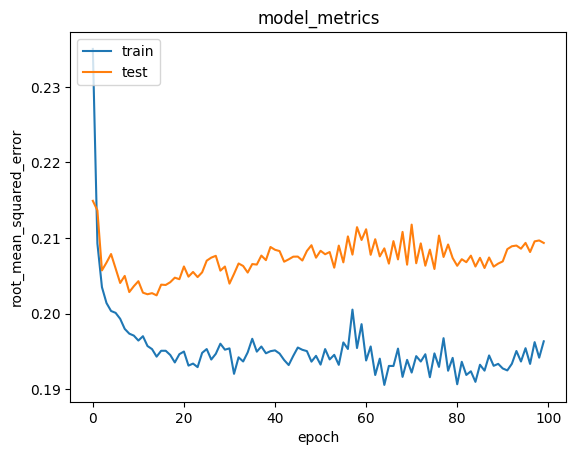

In [46]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plot di atas menunjukkan nilai *root mean squared error* (RMSE) dari data latih (train) dan data uji (test) seiring bertambahnya *epoch*. Awalnya, RMSE pada kedua data menurun, menunjukkan model belajar dengan baik. Namun, setelah *epoch* 10-20, RMSE pada data uji mulai stabil dan sedikit meningkat, sementara RMSE pada data latih terus menurun. Ini adalah tanda *overfitting*, di mana model hanya bekerja baik pada data latih, tetapi tidak pada data uji. Untuk mengatasi hal ini, metode seperti *regularization*, *dropout*, atau *early stopping* dapat diterapkan agar model lebih baik dalam menggeneralisasi data baru.

**5. Mendapatkan rekomendasi film**

In [47]:
data_df = movies_dict
df = pd.read_csv('/content/ml-latest-small/ratings.csv')

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]

movies_not_watched = data_df[~data_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))

In [48]:
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_encoded_to_movie[movies_not_watched[i][0]] for i in top_ratings_indices]

print(f'Menampilkan rekomendasi untuk pengguna: {user_id}')
print('=' * 32)
print('Film dengan rating tinggi dari pengguna')
print('-' * 32)

# Menampilkan 5 film dengan rating tertinggi dari pengguna
top_movies_user = movies_watched_by_user.nlargest(5, 'rating').movieId.values
for _, row in movies_df[movies_df['movieId'].isin(top_movies_user)].iterrows():
    print(f"{row.title} : {row.genres}")

print('-' * 32)
print('10 film teratas yang direkomendasikan')
print('-' * 32)

# Menampilkan 10 film teratas yang direkomendasikan
for _, row in movies_df[movies_df['movieId'].isin(recommended_movie_ids)].iterrows():
    print(f"{row.title} : {row.genres}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Menampilkan rekomendasi untuk pengguna: 231
Film dengan rating tinggi dari pengguna
--------------------------------
Terminator 2: Judgment Day (1991) : Action|Sci-Fi
Die Hard (1988) : Action|Crime|Thriller
Aliens (1986) : Action|Adventure|Horror|Sci-Fi
Matrix, The (1999) : Action|Sci-Fi|Thriller
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
--------------------------------
10 film teratas yang direkomendasikan
--------------------------------
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964) : Drama|Musical|Romance
Paths of Glory (1957) : Drama|War
Awful Truth, The (1937) : Comedy|Romance
Come and See (Idi i smotri) (1985) : Drama|War
Midnight Clear, A (1992) : Drama|War
Adam's Rib (1949) : Comedy|Romance
Jetée, La (1962) : Romance|Sci-Fi
Reefer Madness: The Movie Musical (2005) : Comedy|Drama|Musical
Neon Genesis Evangelion: Death & Rebirth (Shin seiki Evangelion Gekijô-ban: Shito shinsei) (1997) : Action|Animation|Mystery|Sc

In [49]:
# Membuat tabel untuk film dengan rating tertinggi dari pengguna
top_movies_user_df = movies_df[movies_df['movieId'].isin(top_movies_user)][['title', 'genres']]
print(f'Menampilkan rekomendasi untuk pengguna: {user_id}')
print('=' * 50)
print('Film dengan rating tertinggi dari pengguna:')
print('-' * 50)
print(top_movies_user_df.to_string(index=False))

print('\n' + '-' * 50)
print('10 film teratas yang direkomendasikan:')
print('-' * 50)

# Membuat tabel untuk 10 film teratas yang direkomendasikan
recommended_movies_df = movies_df[movies_df['movieId'].isin(recommended_movie_ids)][['title', 'genres']]
print(recommended_movies_df.to_string(index=False))

Menampilkan rekomendasi untuk pengguna: 231
Film dengan rating tertinggi dari pengguna:
--------------------------------------------------
                            title                         genres
Terminator 2: Judgment Day (1991)                  Action|Sci-Fi
                  Die Hard (1988)          Action|Crime|Thriller
                    Aliens (1986) Action|Adventure|Horror|Sci-Fi
               Matrix, The (1999)         Action|Sci-Fi|Thriller
          Dark Knight, The (2008)        Action|Crime|Drama|IMAX

--------------------------------------------------
10 film teratas yang direkomendasikan:
--------------------------------------------------
                                                                                            title                          genres
                                Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)           Drama|Musical|Romance
                                                                     